In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Load and pre-process data

### 1) Global parameters

In [2]:
SOURCE_PATH = os.path.dirname(os.getcwd())

TRAIN_SIZE = 0.7 # size of training data (in %)
VALIDATION_SIZE = 0.2
N_JOBS = 1  # number of jobs to run in parallel
N_SPLITS = 10  # number of splits (k) to be made within the k fold cv
N_ITER = 3  # number of parameter settings that are sampled
SEED = 2294
VERBOSE = True
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAG = "FFNN"
STANDARDIZE = True

### 2) Local parameters

In [3]:
DIR_NAMES = os.listdir(os.path.join(INPUTS_PATH))

dgp_name = DIR_NAMES[0]
ds = DATASET_NAMES[0] 

In [4]:
data = pd.read_csv(os.path.join(INPUTS_PATH, dgp_name, ds + ".csv"))
y = data["betas_dgp"].to_numpy()
X = data[["cov_dgp"]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=(1 - VALIDATION_SIZE))

if STANDARDIZE:
    scaler = StandardScaler()
    X_train_zscore = scaler.fit_transform(X_train)
    X_validation_zscore = scaler.transform(X_validation)
    X_test_zscore = scaler.transform(X_test)

In [5]:
X_train.shape

(18000, 1)

In [6]:
X_validation.shape

(4500, 1)

In [7]:
data.tail()

,Var1,Var2,betas_dgp,cov_dgp
22495,150,146,0.0,-0.010756
22496,150,147,0.0,-0.162996
22497,150,148,0.0,-0.022190
22498,150,149,0.0,-0.065551
22499,150,150,0.0,1.000000


array([[<AxesSubplot:title={'center':'betas_dgp'}>]], dtype=object)

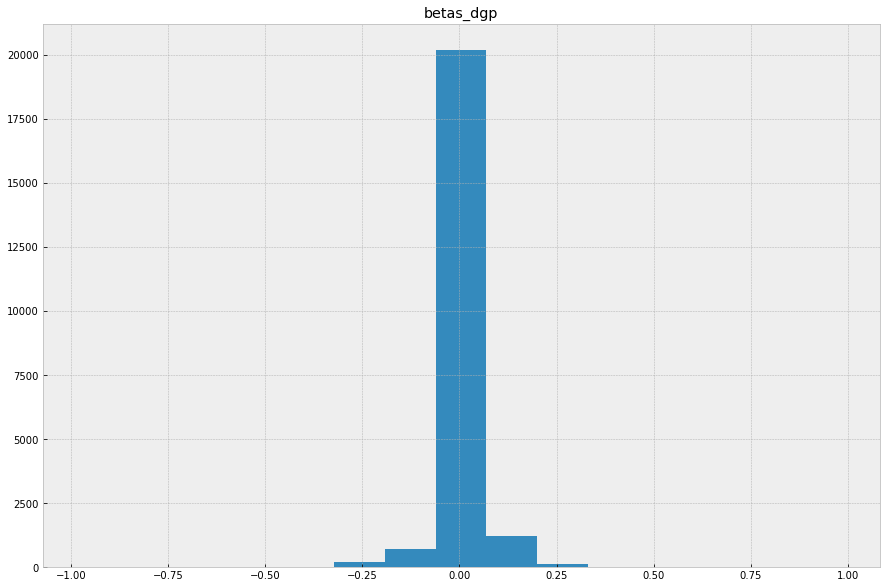

In [8]:
data[["betas_dgp"]].hist(bins=15)

array([[<AxesSubplot:title={'center':'cov_dgp'}>]], dtype=object)

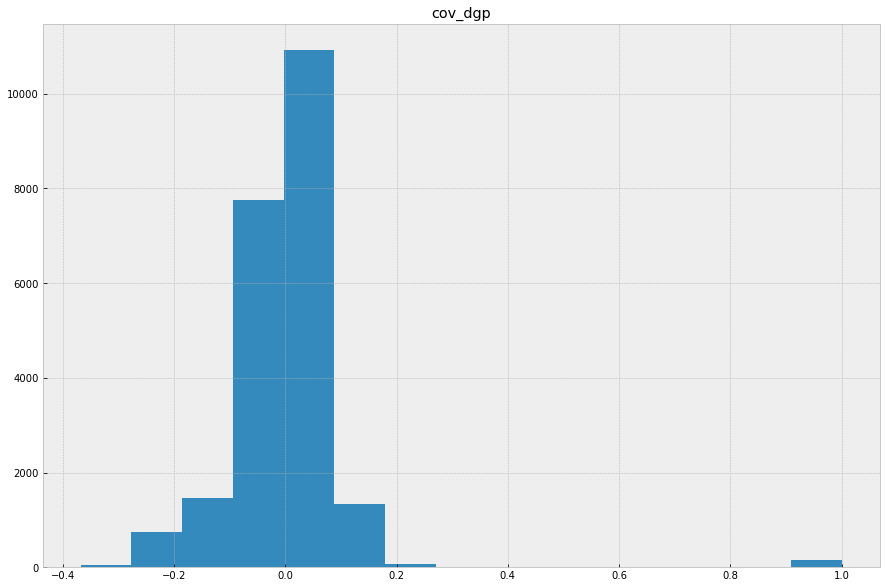

In [9]:
data[["cov_dgp"]].hist(bins=15)

## Model

### 1) Definition and Estimation

We will use the "LinearRegrssion" object of the sklearn package to define the linear regression model object. Since this model has no hyperparameters, we go straight to the estimation of the model parameters on the training data.

In [25]:
# define the FNN model
def FFNN(n_hidden,
         n_neurons,
         input_shape,
         activation="relu",
         learning_rate=3e-3,
         loss="mse"):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    # for layer in range(n_hidden):
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
        model.add(keras.layers.Dense(1))        
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

            
# transform the FNN model into a sklearn regressor object
FFNNReg = keras.wrappers.scikit_learn.KerasRegressor(FFNN)

# define wrapper around the FNN regressor
class FFNNWrapper():
    def __init__(self, model_params=None):
        self.model_name = "ffnn"
        self.search_type = 'random'
        self.param_grid = {"n_hidden": [0, 1, 2, 3, 4, 5],
                           "n_neurons": np.arange(1, 100),
                           "activation": ["relu"],
                           "learning_rate": reciprocal(3e-4, 3e-2),
                           "loss": ["mse"]}
        self.ModelClass = FFNNReg
        
        if model_params is not None:
            self.param_grid.update(model_params) 

In [26]:
import numpy as np
from scipy.stats import reciprocal
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV

cv_splits = KFold(n_splits=N_SPLITS)
mse_scorer = make_scorer(mean_squared_error)

In [30]:
wrapper = FFNNWrapper(model_params={"input_shape": [X_train_zscore.shape[1]]})

In [31]:
model_search = RandomizedSearchCV(estimator=wrapper.ModelClass,
                                  param_distributions=wrapper.param_grid,
                                  n_iter=N_ITER,
                                  cv=cv_splits,
                                  verbose=0,
                                  n_jobs=N_JOBS,
                                  scoring=mse_scorer,
                                  random_state=SEED) 

opt_model_search = model_search.fit(X_train_zscore,
                                    y_train,
                                    validation_data=(X_validation_zscore, y_validation))

Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 45us/sample - loss: 0.5432 - val_loss: 0.3859
Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 39us/sample - loss: 0.0060 - val_loss: 0.0056
Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 38us/sample - loss: 0.6024 - val_loss: 0.4170
Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 39us/sample - loss: 0.8966 - val_loss: 0.6315
Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 43us/sample - loss: 0.8286 - val_loss: 0.5867
Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 39us/sample - loss: 0.0688 - val_loss: 0.0517
Train on 16200 samples, validate on 4500 samples
16200/16200 [==============================] - 1s 43us/sample - loss: 0.9728 - va

In [34]:
y_pred2 = opt_model_search.best_estimator_.predict(X_test_zscore)
mse2 = mean_squared_error(y_true=y_test, 
                         y_pred=y_pred2)

results2 = {"y_pred": y_pred2,
            "mse": mse2}
results2

{'y_pred': array([-0.0359428 ,  0.11418074,  0.10875963, ...,  0.10243759,
         0.12839253, -0.87726617], dtype=float32),
 'mse': 0.08487640237325712}